# Cross-Validation for Time Series (scikit-learn) — No Pipeline

**Level:** Entry → Middle  
**Goal:** Learn how to use **TimeSeriesSplit** properly, build simple lag features, run manual CV loops for forecasting models, and evaluate on a true **future** hold-out — **without using `Pipeline`**.

### What you'll practice
- Creating synthetic seasonal time series for experimentation
- Building lag / rolling features manually
- Baselines (naïve `y(t-1)`)
- `TimeSeriesSplit` with expanding window
- Manual CV loop for `LinearRegression` and `RandomForestRegressor`
- Simple hyperparameter search with CV
- Final test evaluation and forecast plot
- Fixed-window vs expanding-window CV


In [1]:
# 0) Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import __version__ as sk_version
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Versions -> numpy:', np.__version__, '| pandas:', pd.__version__, '| scikit-learn:', sk_version)

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0


Versions -> numpy: 2.3.1 | pandas: 2.3.1 | scikit-learn: 1.7.1


## 1) Create a synthetic monthly time series (trend + seasonality + noise)


In [2]:
periods = 200  # ~16.6 years of monthly data
date_index = pd.date_range('2008-01-01', periods=periods, freq='MS')

trend = np.linspace(10, 30, periods)                # upward trend
seasonal = 5 * np.sin(2 * np.pi * (np.arange(periods) / 12))  # yearly seasonality
noise = np.random.normal(0, 1.5, periods)          # noise
y = trend + seasonal + noise

df = pd.DataFrame({'date': date_index, 'y': y}).set_index('date')
df.head()


,y
date,
2008-01-01,10.745071
2008-02-01,12.393106
2008-03-01,15.502665
2008-04-01,17.586052
2008-05-01,14.380907


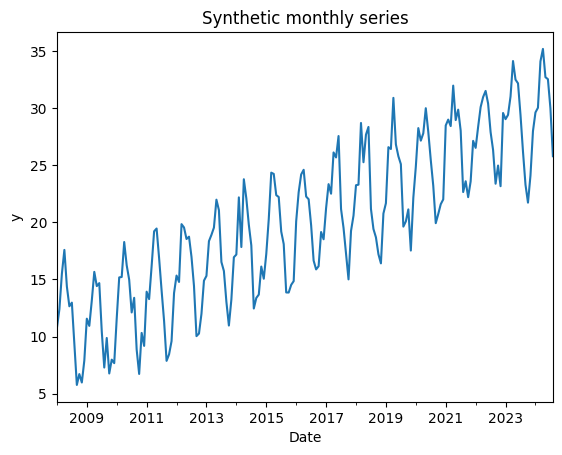

In [3]:
# Plot the series
plt.figure()
df['y'].plot()
plt.title('Synthetic monthly series')
plt.xlabel('Date')
plt.ylabel('y')
plt.show()


## 2) Train/test split by time

We'll reserve the most recent ~24 months for **testing** (future hold-out).


In [4]:
test_horizon = 24
train_df = df.iloc[:-test_horizon].copy()
test_df = df.iloc[-test_horizon:].copy()
len(train_df), len(test_df), train_df.index.min(), train_df.index.max(), test_df.index.min(), test_df.index.max()


(176,
 24,
 Timestamp('2008-01-01 00:00:00'),
 Timestamp('2022-08-01 00:00:00'),
 Timestamp('2022-09-01 00:00:00'),
 Timestamp('2024-08-01 00:00:00'))

## 3) Build lag and rolling features (manually, no Pipeline)

We'll create: `lag_1`, `lag_12`, 3-month and 12-month moving averages.  
> **Note:** In real projects, add more meaningful calendar/exogenous features if available.


In [5]:
def make_features(data):
    out = data.copy()
    out['lag_1'] = out['y'].shift(1)
    out['lag_12'] = out['y'].shift(12)
    out['roll_mean_3'] = out['y'].shift(1).rolling(3).mean()
    out['roll_mean_12'] = out['y'].shift(1).rolling(12).mean()
    return out

feat = make_features(df)
feat = feat.dropna()  # drop first rows without enough history
feat.head()


,y,lag_1,lag_12,roll_mean_3,roll_mean_12
date,,,,,
2009-01-01,11.568974,7.906933,10.745071,6.868356,10.996697
2009-02-01,10.936612,11.568974,12.393106,8.485226,11.065355
2009-03-01,13.149785,10.936612,15.502665,10.137506,10.943981
2009-04-01,15.664106,13.149785,17.586052,11.885124,10.747908
2009-05-01,14.418921,15.664106,14.380907,13.250168,10.587745


We'll align features and target, then re-split by time.


In [6]:
X = feat[['lag_1', 'lag_12', 'roll_mean_3', 'roll_mean_12']].copy()
y = feat['y'].copy()

# Recompute split indices after feature creation
test_start_idx = len(train_df) - (len(df) - len(feat))  # adjust for dropped NaNs
X_train, y_train = X.iloc[:test_start_idx], y.iloc[:test_start_idx]
X_test, y_test = X.iloc[test_start_idx:], y.iloc[test_start_idx:]

X_train.shape, X_test.shape


((164, 4), (24, 4))

## 4) Baseline: Naïve forecast `y_hat(t) = y(t-1)`


In [7]:
# For the naive forecast, use the 'lag_1' feature directly for the test period
y_pred_naive = X_test['lag_1'].values

print('Naive MAE:', mean_absolute_error(y_test, y_pred_naive))
print('Naive RMSE:', rmse(y_test, y_pred_naive))
print('Naive MAPE (%):', mape(y_test, y_pred_naive))


Naive MAE: 2.2342382059109407


TypeError: got an unexpected keyword argument 'squared'

## 5) Understand `TimeSeriesSplit` (expanding window)

We'll visualize where each fold's train/validation split happens.


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

split_points = []
for i, (tr, va) in enumerate(tscv.split(X_train), start=1):
    split_points.append((i, tr[-1], va[0]-1, va[-1]))  # last train idx, val start idx-1, val end idx

print('Fold | last_train_idx | val_start_idx | val_end_idx')
for r in split_points:
    print('%4d | %14d | %13d | %10d' % r)

# Plot the training series with vertical lines at validation starts
plt.figure()
plt.plot(y_train.values)
for _, _, vstart, _ in split_points:
    plt.axvline(x=vstart, linestyle='--')
plt.title('TimeSeriesSplit fold boundaries (on training set)')
plt.xlabel('Index')
plt.ylabel('y')
plt.show()


## 6) Manual CV loop: Linear Regression with `TimeSeriesSplit`

We fit only on the training indices of each fold and score on the validation indices.


In [ ]:
lin_maes, lin_rmses = [], []
tscv = TimeSeriesSplit(n_splits=5)

for fold, (tr, va) in enumerate(tscv.split(X_train), start=1):
    X_tr, X_va = X_train.iloc[tr], X_train.iloc[va]
    y_tr, y_va = y_train.iloc[tr], y_train.iloc[va]

    lin = LinearRegression()
    lin.fit(X_tr, y_tr)
    p = lin.predict(X_va)

    mae = mean_absolute_error(y_va, p)
    r = rmse(y_va, p)
    lin_maes.append(mae)
    lin_rmses.append(r)

    print(f'Fold {fold} -> MAE={mae:.3f}, RMSE={r:.3f}')

print('\nLinearRegression CV MAE: %.3f ± %.3f' % (np.mean(lin_maes), np.std(lin_maes)))
print('LinearRegression CV RMSE: %.3f ± %.3f' % (np.mean(lin_rmses), np.std(lin_rmses)))


## 7) Manual CV + simple hyperparameter search: Random Forest

We'll try a few `(n_estimators, max_depth)` pairs and pick the best by mean RMSE.


In [ ]:
param_grid = [(50, None), (100, None), (200, None), (100, 5), (200, 5), (200, 8)]
results = []

tscv = TimeSeriesSplit(n_splits=5)

for n_est, depth in param_grid:
    rmses = []
    for tr, va in tscv.split(X_train):
        rf = RandomForestRegressor(
            n_estimators=n_est, max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1
        )
        rf.fit(X_train.iloc[tr], y_train.iloc[tr])
        p = rf.predict(X_train.iloc[va])
        rmses.append(rmse(y_train.iloc[va], p))
    results.append((n_est, depth, np.mean(rmses), np.std(rmses)))

res_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'mean_rmse', 'std_rmse']).sort_values('mean_rmse')
print(res_df)

best_row = res_df.iloc[0]
best_params = int(best_row['n_estimators']), (None if pd.isna(best_row['max_depth']) else int(best_row['max_depth']))
print('\nBest params (n_estimators, max_depth):', best_params)


## 8) Fit the best model on the full training set and evaluate on the **future** test set


In [ ]:
best_n, best_depth = best_params
best_rf = RandomForestRegressor(
    n_estimators=best_n, max_depth=best_depth, random_state=RANDOM_STATE, n_jobs=-1
)
best_rf.fit(X_train, y_train)
pred_test = best_rf.predict(X_test)

print('Test MAE:', mean_absolute_error(y_test, pred_test))
print('Test RMSE:', rmse(y_test, pred_test))
print('Test MAPE (%):', mape(y_test, pred_test))

# Plot actual vs predicted
plt.figure()
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, pred_test, label='Predicted')
plt.title('Test period: actual vs predicted')
plt.xlabel('Date')
plt.ylabel('y')
plt.legend()
plt.show()


## 9) Fixed-window CV (rolling origin with limited history)

Sometimes you want to keep a **fixed training window** size to mimic memory constraints or concept drift.


In [ ]:
window = 60  # use last 60 points as training window
n_splits = 5
indices = np.arange(len(X_train))

# Build rolling splits manually
splits = []
fold_size = len(X_train) // (n_splits + 1)
for k in range(1, n_splits + 1):
    end = (k + 1) * fold_size
    start = max(0, end - window)
    val_start = end
    val_end = min(len(X_train), val_start + fold_size)
    tr_idx = indices[start:end]
    va_idx = indices[val_start:val_end]
    if len(va_idx) == 0:
        break
    splits.append((tr_idx, va_idx))

rmses_fw = []
for fold, (tr, va) in enumerate(splits, start=1):
    lin = LinearRegression()
    lin.fit(X_train.iloc[tr], y_train.iloc[tr])
    p = lin.predict(X_train.iloc[va])
    r = rmse(y_train.iloc[va], p)
    rmses_fw.append(r)
    print(f'Fold {fold} -> RMSE={r:.3f}')

print('\nFixed-window LinearRegression CV RMSE: %.3f ± %.3f' % (np.mean(rmses_fw), np.std(rmses_fw)))


## 10) Exercises
1. Add more lags (e.g., 2–6, 24) and re-run CV — did the model improve?
2. Try `ElasticNet` and standardize features **inside each fold** manually if you add scaling-sensitive models.
3. Compare expanding-window vs fixed-window CV across different forecast horizons.
4. Replace the synthetic series with your own real dataset and repeat the workflow.
